# Omdena  - Milan Chapter Agrifoods
## AI for Sustainable agri-food systems: use of Satellite Imagery
### Exploratory analysis of cereals production in Italy 2020-2022
#### Author: Maria Fisher 


Here we have analysed the major areas and crop produced in Italy. 
Crop dataset used in this study was downloaded from the Italian National Institute of Statistics (Istat).
The objective is to get some insights about crop production and its respective areas in Italy and how climate change have affected crop production in the last 3 years. 
Maps was created with dataset from Simone Rigoni, the address to the repository of the dataset i avaialbe in References.   


In [1]:
import warnings 
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns 
import scipy 
import sklearn
import geopandas as gpd
import pgeocode
import folium
import sys
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

In [2]:
cereals = pd.read_csv('Italy_crop_data/italy_cereals.csv')
cereals.head()

,ITTER107,Territory,TIPO_DATO5,Data type,AGRI_MADRE,Type of crop,TIME,Select time,Value,Flag Codes,Flags
0,ITC11,Torino,ART,total area - hectares,COMMEAT,common wheat,2020,2020,15362,NaN,NaN
1,ITC11,Torino,ART,total area - hectares,COMMEAT,common wheat,2021,2021,16831,NaN,NaN
2,ITC11,Torino,ART,total area - hectares,COMMEAT,common wheat,2022,2022,16735,NaN,NaN
3,ITC12,Vercelli,ART,total area - hectares,COMMEAT,common wheat,2020,2020,1285,NaN,NaN
4,ITC12,Vercelli,ART,total area - hectares,COMMEAT,common wheat,2021,2021,1491,NaN,NaN


## Pre-processing dataset 

In [3]:
cereals = cereals.drop(columns =['ITTER107','TIPO_DATO5','AGRI_MADRE', 'TIME', 'Flag Codes','Flags' ])
cereals

,Territory,Data type,Type of crop,Select time,Value
0,Torino,total area - hectares,common wheat,2020,15362
1,Torino,total area - hectares,common wheat,2021,16831
2,Torino,total area - hectares,common wheat,2022,16735
3,Vercelli,total area - hectares,common wheat,2020,1285
4,Vercelli,total area - hectares,common wheat,2021,1491
...,...,...,...,...,...
4767,Pesaro e Urbino,total area - hectares,rye and winter cereal mixtures (maslin),2022,3
4768,Roma,total area - hectares,rye and winter cereal mixtures (maslin),2022,20
4769,Valle d'Aosta / Vallée d'Aoste,total area - hectares,winter barley,2022,1
4770,Torino,total area - hectares,spring barley,2022,220


In [4]:
cereals = cereals.rename(columns = {'Select time':'Year', 'Type of crop':'Type_crop', 'Data type':'Data_type', 'Territory':'City'})


In [5]:
def show_info(cereals):
    print('DATASET SHAPE: ', cereals.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(cereals.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(cereals.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(cereals.isnull().sum())
show_info(cereals)

DATASET SHAPE:  (4772, 5) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4772 entries, 0 to 4771
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   City       4772 non-null   object
 1   Data_type  4772 non-null   object
 2   Type_crop  4772 non-null   object
 3   Year       4772 non-null   int64 
 4   Value      4772 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 186.5+ KB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

City          108
Data_type       1
Type_crop      29
Year            3
Value        1210
dtype: int64

 --------------------------------------------------
NULL VALUES PER FEATURE
City         0
Data_type    0
Type_crop    0
Year         0
Value        0
dtype: int64


## Cities in Italy producing cereals

In [6]:
cereals.City.unique()


array(['Torino', 'Vercelli', 'Biella', 'Verbano-Cusio-Ossola', 'Novara',
       'Cuneo', 'Asti', 'Alessandria', "Valle d'Aosta / Vallée d'Aoste",
       'Savona', 'Genova', 'La Spezia', 'Varese', 'Como', 'Lecco',
       'Sondrio', 'Milano', 'Bergamo', 'Brescia', 'Pavia', 'Lodi',
       'Cremona', 'Mantova', 'Trentino Alto Adige / Südtirol', 'Verona',
       'Vicenza', 'Belluno', 'Treviso', 'Venezia', 'Padova', 'Rovigo',
       'Pordenone', 'Udine', 'Gorizia', 'Piacenza', 'Parma',
       "Reggio nell'Emilia", 'Modena', 'Bologna', 'Ferrara', 'Ravenna',
       'Forlì-Cesena', 'Rimini', 'Massa-Carrara', 'Lucca', 'Pistoia',
       'Firenze', 'Prato', 'Livorno', 'Pisa', 'Arezzo', 'Siena',
       'Grosseto', 'Perugia', 'Terni', 'Pesaro e Urbino', 'Ancona',
       'Macerata', 'Ascoli Piceno', 'Viterbo', 'Rieti', 'Roma', 'Latina',
       'Frosinone', "L'Aquila", 'Teramo', 'Pescara', 'Chieti', 'Isernia',
       'Campobasso', 'Caserta', 'Benevento', 'Avellino', 'Salerno',
       'Foggia', 'Bari',

## Total cereal production in 2020-2022

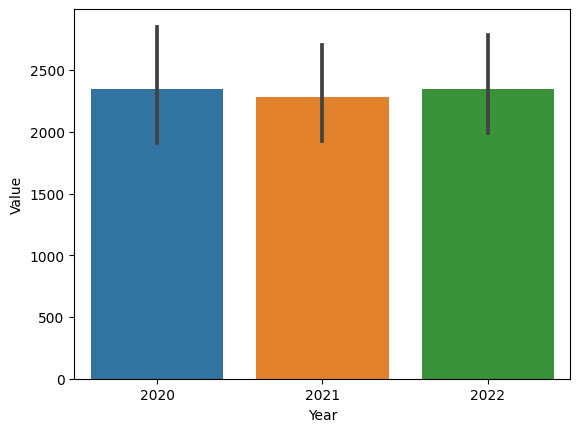

In [7]:

sns.barplot(x= 'Year', y= 'Value',data = cereals)
plt.show()



## Cereal production by Cities 

In [8]:
cereals_region = cereals.groupby(by = cereals.City)['Value','City'].sum().reset_index().sort_values(by = 'Value', ascending = False).head(10)
cereals_region

,City,Value
33,Foggia,829495
31,Ferrara,355489
72,Potenza,342289
64,Pavia,292440
65,Perugia,291294
13,Bologna,275519
62,Palermo,271150
81,Rovigo,261383
1,Alessandria,260241
92,Torino,257790


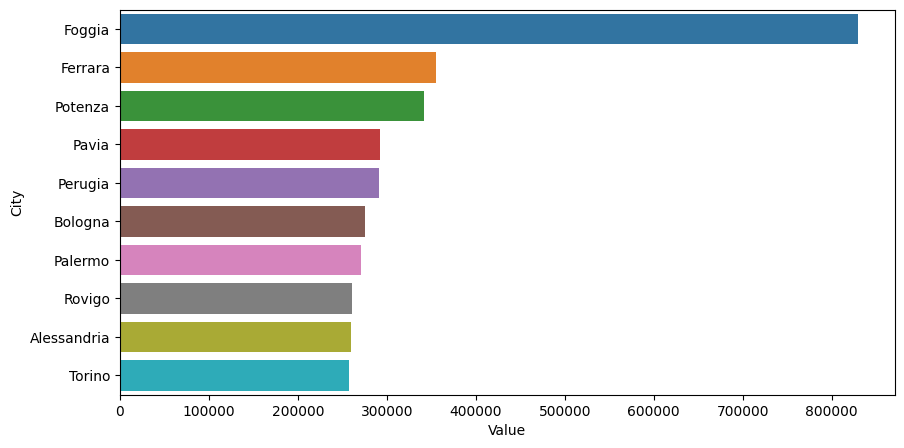

In [9]:
plt.figure(figsize= (10,5))
sns.barplot(x=cereals_region['Value'],y= cereals_region['City'], orient='h');

## Italy geographic areas is organized in regions, provinces or comunes. 
### The regions are classified as follow:


#### Sud/Mezzogiorno:  

Abruzzo, Apulia/Puglia, Basilicata, Calabria, Campania, Molise, Sicily 

* Abruzzo: L'Aquila, Pescara, Chieti, Teramo

* Apulia/Puglia: Foggia, Bari, Taranto, Brindisi, Lecce, Barletta-Andria-Trani

* Basilicata: Matera, Potenza

* Calabria: Crotone, Vibo, Valentia, Cosenza, Catanzaro, Reggio di Calabria

* Campania: Benevento, Caserta, Napoli, Avellino, Salerno

* Molise: Campobasso, Isernia

* Sicilia: Messina,Siracusa, Agrigento, Caltanissetta, Trapani, Enna, Palermo, Catania, Ragusa

* Sardegna: Oristano, Carbonia-Iglesias, Olbia-Tempio, Ogliastr, Medio Campidano, Sassari, Nuoro, Cagliari



#### Centro: 

Toscana, Umbria, Marche, Lazio

* Toscana: Pistoia, Firenze, Massa-Carrara, Lucca, Arezzo, Livorno, Pisa, Grosseto, Siena, Prato

* Umbria: Perugia, Terni   

* Marche: Ancona, Macerata, Ascoli Piceno, Pesaro e Urbino, Fermo

* Lazio:  Roma, Viterbo, Rieti, Latina, Frosinone


#### Nord-ovest: 

Piemonte, Valle d’Aosta, Lombardia, Liguria

* Liguria: Imperia, Savona, Genova, La Spezia

* Lombardia: Como, Varese, Milano, Pavia, Bergamo, Brescia, Sondrio, Cremona, Mantova, Monza e Della Brianza, Lecco,Lodi

* Piemonte: Vercelli, Novara, Torino, Cuneo, Asti, Alessandria, Biella, Verbano-Cusio-Ossola

* Valdaosta:  Valle d'Aosta


#### Nord-est:

Trentino-Alto Adige, Veneto, Fiuli-Venezia Giulia, Emilia-Romagna


* Trentino: Bolzano/Bozen, Trento

* Veneto:  Belluno, Verona, Vicenza, Rovigo, Treviso, Venezia, Padova

* Friuli: Udine, Gorizia, Trieste, Pordenone

* Emilia-Romagna: Parma, Reggio Nell'Emilia, Piacenza, Forli'-Cesena, Modena, Bologna, Ferrara, Ravenna, Rimini











## The most produced cereals 2020-2022

In [10]:
print(cereals.Type_crop.max())
print(cereals.Type_crop.value_counts())
print(cereals.Type_crop.nunique())



winter cereal mixtures (maslin)
potatoes                                                           314
barley                                                             300
oats                                                               289
durum wheat                                                        286
common wheat                                                       284
grain maize                                                        284
broad bean                                                         238
chick-peas                                                         232
other cereals                                                      226
dried kidney bean                                                  218
sorghum                                                            217
oats and spring cereal mixtures (mixed grain other than maslin)    194
protein pea                                                        190
winter barley                                

Dataset shows there are 29 different types of cereals cultivated in Italy. The top five most produced crops are Wheat, Barley, Maize, Beans and Oats. 

In [11]:
cereals.describe()

,Year,Value
count,4772.000000,4772.000000
mean,2021.059514,2322.713118
std,0.792320,8749.632383
min,2020.000000,0.000000
25%,2020.000000,30.000000
50%,2021.000000,150.000000
75%,2022.000000,1302.500000
max,2022.000000,240000.000000


<AxesSubplot: >

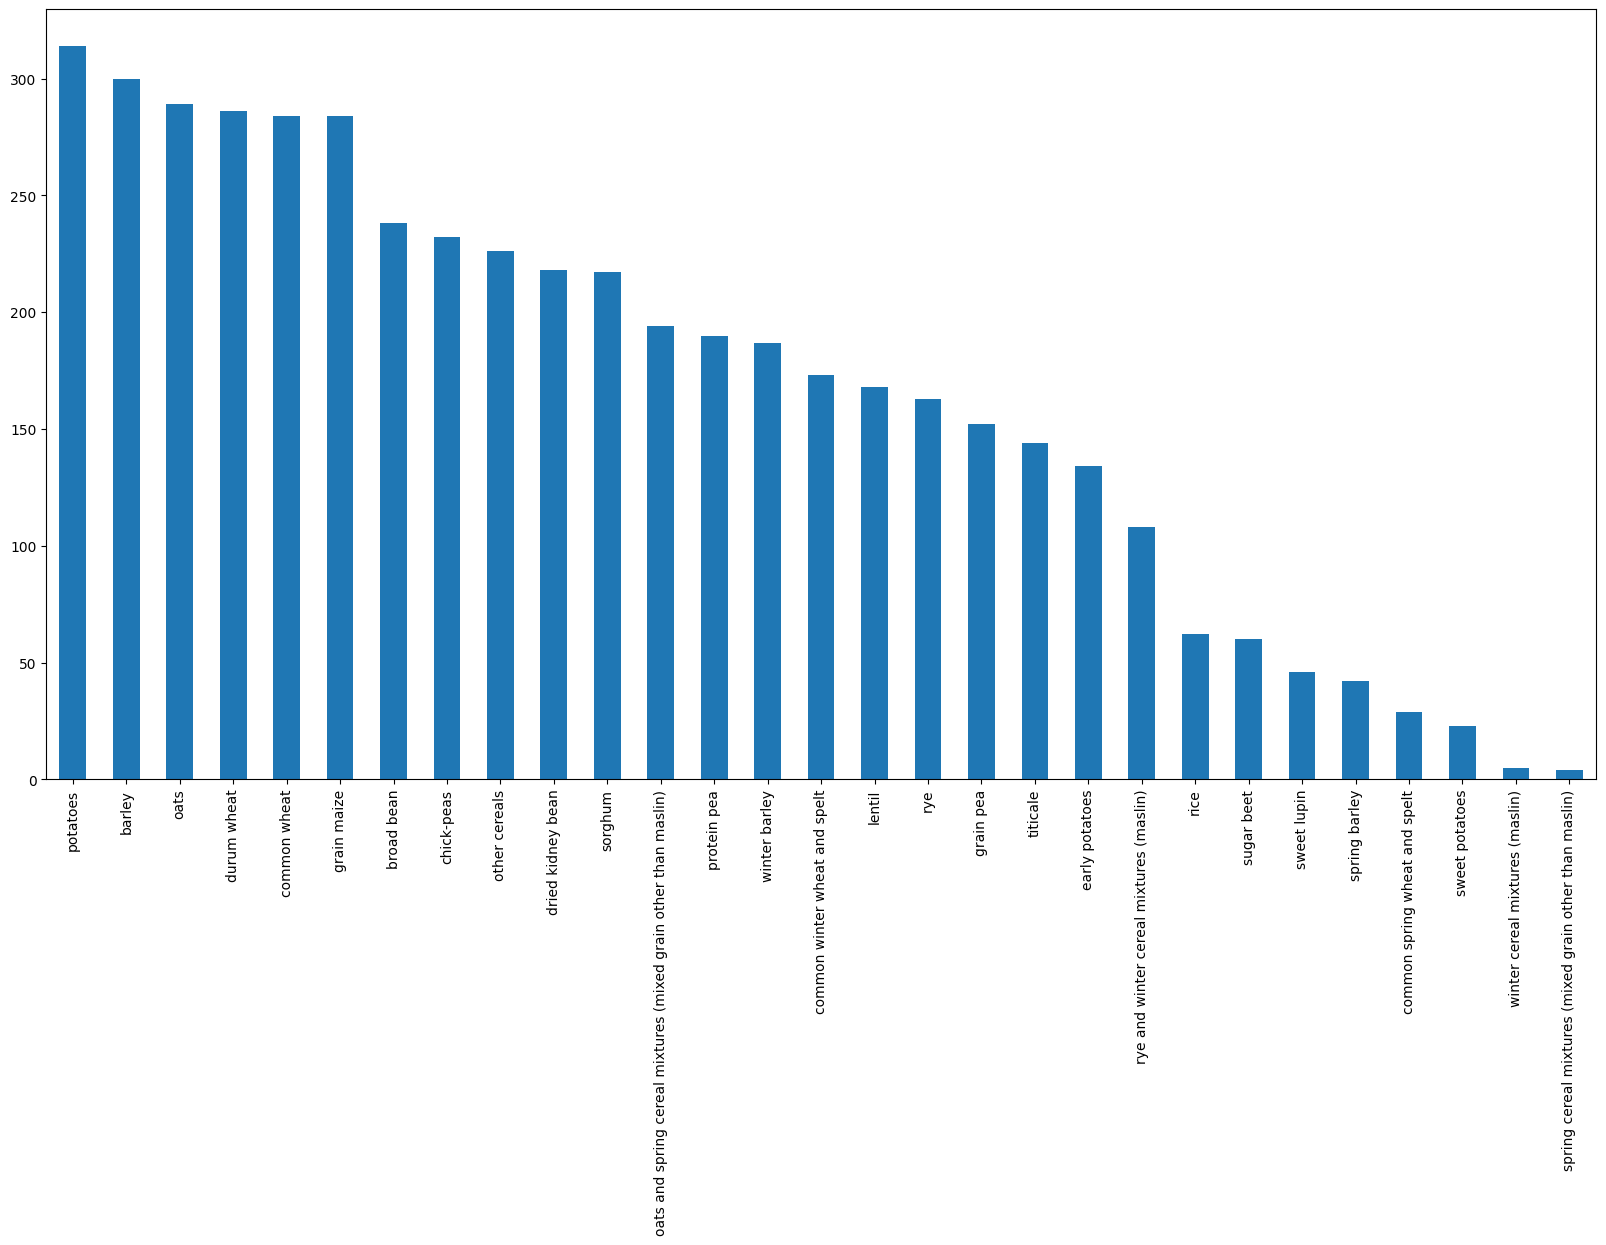

In [12]:
plt.figure(figsize=(20,10))
cereals ['Type_crop'].value_counts().plot.bar()

## Subseting data

In [53]:
cereals_top10 = cereals.apply(lambda row: row[cereals['Type_crop'].isin(['winter cereal mixtures (maslin)','dried kidney bean','barley','oats', 
                                         'durum wheat','common wheat', 'grain maize', 'chick-peas',
                                                   'broad bean', 'rice'])])

cereals_top10.head()

,City,Data_type,Type_crop,Year,Value
0,Torino,total area - hectares,common wheat,2020,15362
1,Torino,total area - hectares,common wheat,2021,16831
2,Torino,total area - hectares,common wheat,2022,16735
3,Vercelli,total area - hectares,common wheat,2020,1285
4,Vercelli,total area - hectares,common wheat,2021,1491


## Stats

In [54]:
cereals_top10.describe().astype(int)

,Year,Value
count,2198,2198
mean,2020,3997
std,0,12345
min,2020,0
25%,2020,47
50%,2021,455
75%,2022,2855
max,2022,240000


<AxesSubplot: xlabel='Value', ylabel='Type_crop'>

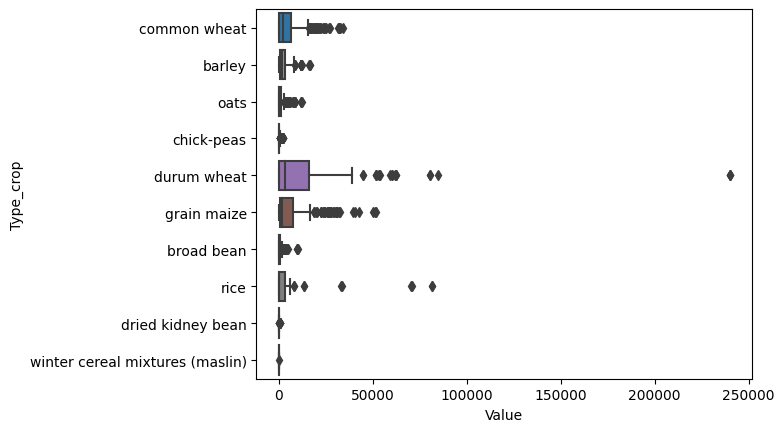

In [55]:

sns.boxplot(y='Type_crop',x='Value',data=cereals_top10) 

## Vizualization of ten type cereal produced in Italy in the period of 2020-2022 

<AxesSubplot: title={'center': 'Common wheat 2020-2022'}, xlabel='Year'>

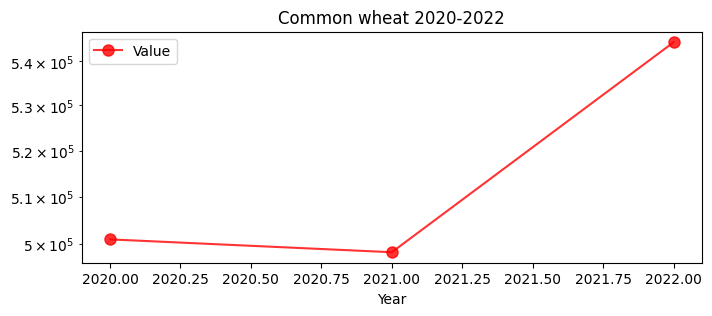

In [56]:

cereals_plot = cereals_top10[['Type_crop','Year', 'Value']]
cereals_plot['Year'] = cereals_plot['Year'].astype(int)
y='common wheat'
cereals_plot = cereals_plot.groupby('Type_crop').get_group(y)
cereals_plot = cereals_plot.groupby('Year')[['Value']].sum()

cereals_plot.plot(figsize=(8,3), logy=True, color=['red'], 
                               linestyle='solid', marker='o', alpha=0.8, markersize=8,
                     title = 'Common wheat 2020-2022')


<AxesSubplot: title={'center': 'Barley 2020-2022'}, xlabel='Year'>

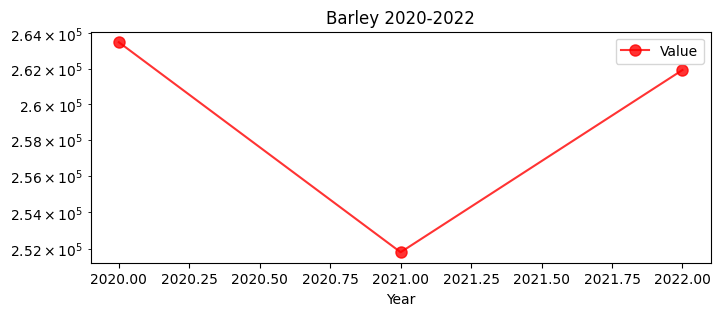

In [57]:

cereals_plot = cereals_top10[['Type_crop','Year', 'Value']]
cereals_plot['Year'] = cereals_plot['Year'].astype(int)
y='barley'
cereals_plot = cereals_plot.groupby('Type_crop').get_group(y)
cereals_plot = cereals_plot.groupby('Year')[['Value']].sum()

cereals_plot.plot(figsize=(8,3), logy=True, color=['red'], 
                               linestyle='solid', marker='o', alpha=0.8, markersize=8,
                  title = 'Barley 2020-2022')

<AxesSubplot: title={'center': 'Winter cereal mixtures 2020-2022'}, xlabel='Year'>

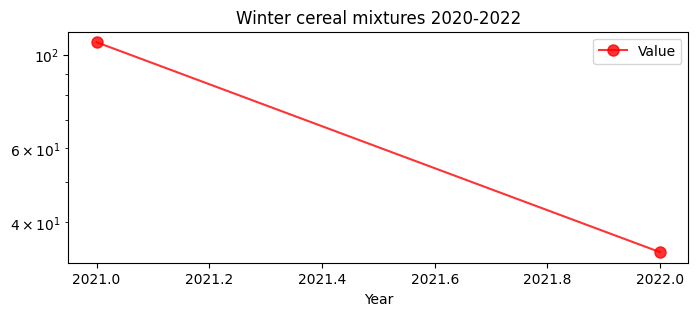

In [58]:

cereals_plot = cereals_top10[['Type_crop','Year', 'Value']]
cereals_plot['Year'] = cereals_plot['Year'].astype(int)
y='winter cereal mixtures (maslin)'
cereals_plot = cereals_plot.groupby('Type_crop').get_group(y)
cereals_plot = cereals_plot.groupby('Year')[['Value']].sum()

cereals_plot.plot(figsize=(8,3), logy=True, color=['red'], 
                               linestyle='solid', marker='o', alpha=0.8, markersize=8,
                  title = 'Winter cereal mixtures 2020-2022')

<AxesSubplot: title={'center': 'Dried kidney bean 2020-2022'}, xlabel='Year'>

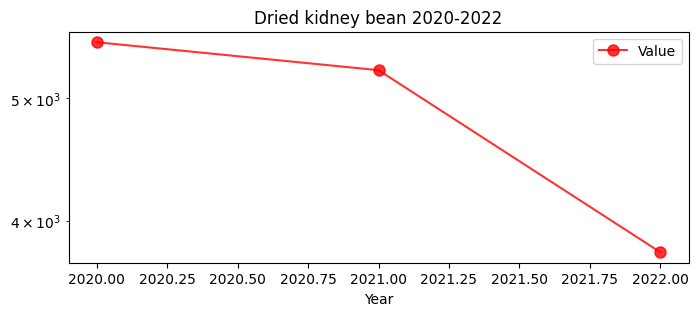

In [61]:

cereals_plot = cereals_top10[['Type_crop','Year', 'Value']]
cereals_plot['Year'] = cereals_plot['Year'].astype(int)
y='dried kidney bean'
cereals_plot = cereals_plot.groupby('Type_crop').get_group(y)
cereals_plot = cereals_plot.groupby('Year')[['Value']].sum()

cereals_plot.plot(figsize=(8,3), logy=True, color=['red'], 
                               linestyle='solid', marker='o', alpha=0.8, markersize=8,
                  title = 'Dried kidney bean 2020-2022')

<AxesSubplot: title={'center': 'Oats 2020-2022'}, xlabel='Year'>

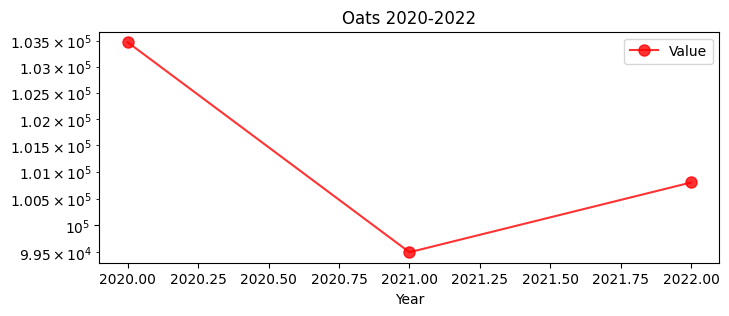

In [62]:

cereals_plot = cereals_top10[['Type_crop','Year', 'Value']]
cereals_plot['Year'] = cereals_plot['Year'].astype(int)
y='oats'
cereals_plot = cereals_plot.groupby('Type_crop').get_group(y)
cereals_plot = cereals_plot.groupby('Year')[['Value']].sum()

cereals_plot.plot(figsize=(8,3), logy=True, color=['red'], 
                               linestyle='solid', marker='o', alpha=0.8, markersize=8,
                  title = 'Oats 2020-2022')

<AxesSubplot: title={'center': 'Durum wheat 2020-2022'}, xlabel='Year'>

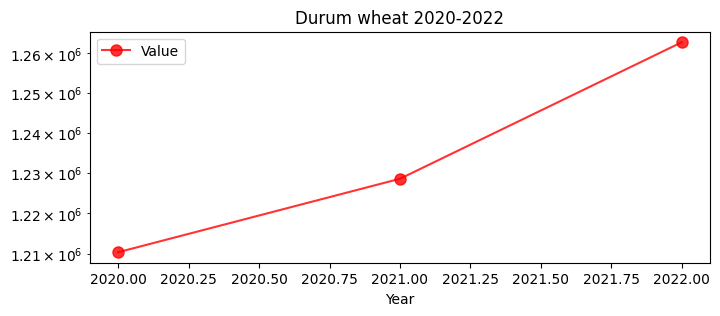

In [63]:

cereals_plot = cereals_top10[['Type_crop','Year', 'Value']]
cereals_plot['Year'] = cereals_plot['Year'].astype(int)
y='durum wheat'
cereals_plot = cereals_plot.groupby('Type_crop').get_group(y)
cereals_plot = cereals_plot.groupby('Year')[['Value']].sum()

cereals_plot.plot(figsize=(8,3), logy=True, color=['red'], 
                               linestyle='solid', marker='o', alpha=0.8, markersize=8,
                  title = 'Durum wheat 2020-2022')

<AxesSubplot: title={'center': 'Grain maize 2020-2022'}, xlabel='Year'>

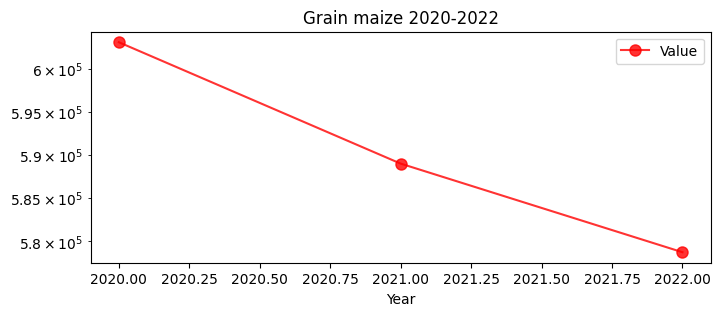

In [64]:

cereals_plot = cereals_top10[['Type_crop','Year', 'Value']]
cereals_plot['Year'] = cereals_plot['Year'].astype(int)
y='grain maize'
cereals_plot = cereals_plot.groupby('Type_crop').get_group(y)
cereals_plot = cereals_plot.groupby('Year')[['Value']].sum()

cereals_plot.plot(figsize=(8,3), logy=True, color=['red'], 
                               linestyle='solid', marker='o', alpha=0.8, markersize=8,
                  title = 'Grain maize 2020-2022')

<AxesSubplot: title={'center': 'Chick-peas 2020-2022'}, xlabel='Year'>

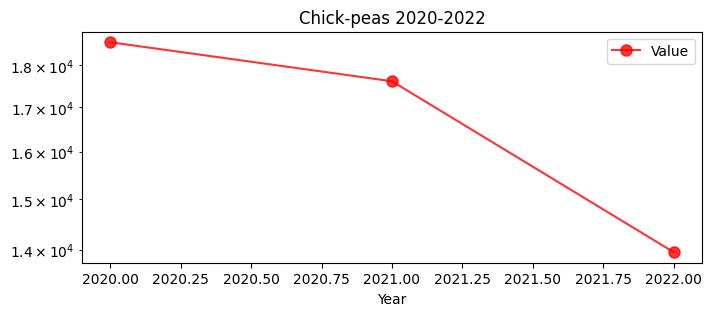

In [65]:

cereals_plot = cereals_top10[['Type_crop','Year', 'Value']]
cereals_plot['Year'] = cereals_plot['Year'].astype(int)
y='chick-peas'
cereals_plot = cereals_plot.groupby('Type_crop').get_group(y)
cereals_plot = cereals_plot.groupby('Year')[['Value']].sum()

cereals_plot.plot(figsize=(8,3), logy=True, color=['red'], 
                               linestyle='solid', marker='o', alpha=0.8, markersize=8,
                  title = 'Chick-peas 2020-2022')

<AxesSubplot: title={'center': 'Broad bean 2020-2022'}, xlabel='Year'>

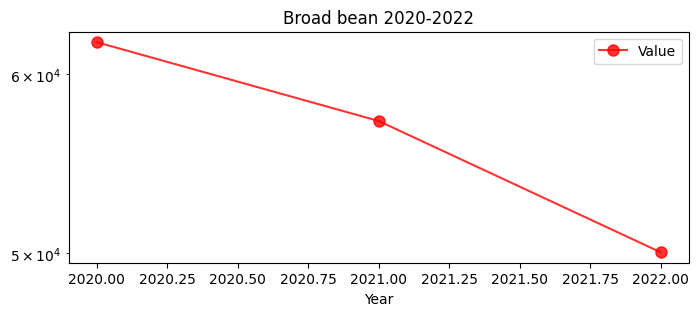

In [66]:

cereals_plot = cereals_top10[['Type_crop','Year', 'Value']]
cereals_plot['Year'] = cereals_plot['Year'].astype(int)
y='broad bean'
cereals_plot = cereals_plot.groupby('Type_crop').get_group(y)
cereals_plot = cereals_plot.groupby('Year')[['Value']].sum()

cereals_plot.plot(figsize=(8,3), logy=True, color=['red'], 
                               linestyle='solid', marker='o', alpha=0.8, markersize=8,
                  title = 'Broad bean 2020-2022')

* Rice is not in the top crop production 
but it is an important crop , therefore I have included for further discussion in the group.  

<AxesSubplot: title={'center': 'Rice 2020-2022'}, xlabel='Year'>

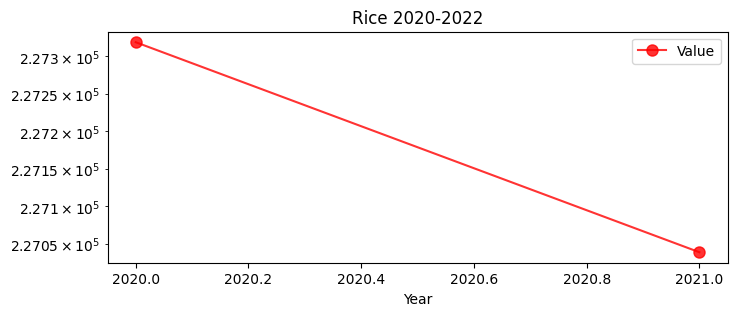

In [67]:

cereals_plot = cereals_top10[['Type_crop','Year', 'Value']]
cereals_plot['Year'] = cereals_plot['Year'].astype(int)

y='rice'
cereals_plot = cereals_plot.groupby('Type_crop').get_group(y)
cereals_plot = cereals_plot.groupby('Year')[['Value']].sum()

cereals_plot.plot(figsize=(8,3), logy=True, color=['red'], 
                               linestyle='solid', marker='o', alpha=0.8, markersize=8,
                  title = 'Rice 2020-2022')

# References


http://dati.istat.it

https://maps.princeton.edu/catalog/stanford-mn871sp9778

https://www.crea.gov.it/documents/68457/0/ITACONTA+2020_ENG+DEF+xweb+%281%29.pdf/95c6b30a-1e18-8e94-d4ac-ce884aef76e8?t=1619527317576